# Testing methods for circular statistics

Some theory explanation: 

- https://bpspsychub.onlinelibrary.wiley.com/doi/full/10.1111/bmsp.12108
- https://ebookcentral.proquest.com/lib/anu/reader.action?docID=1679584
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2017WR021731
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014WR016399
- https://bg.copernicus.org/articles/17/3991/2020/bg-17-3991-2020.html
- https://bpspsychub.onlinelibrary.wiley.com/doi/10.1111/bmsp.12108
- https://academic.oup.com/jrsssc/article/65/3/445/7061324?login=true
- https://www.cell.com/trends/ecology-evolution/fulltext/S0169-5347(22)00112-4
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.circstd.html#scipy.stats.circstd
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.circmean.html

In [1]:
%matplotlib inline

import sys
import pickle
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from scipy.stats import pearsonr, chi2
from scipy.stats import linregress
import pingouin as pg
from scipy.signal import find_peaks

sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology_pixel_circular import mk_with_slopes
from LC_regression import circular_model, fit_circular_model, calculate_beta_significance, permutation_test

Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead


## Open data

In [2]:
#NDVI timeseries processed earlier to daily
timeseries_file = '/g/data/os22/chad_tmp/Aus_phenology/data/pickle/IBRA_subregions_NDVI_AusENDVI-clim_MCD43A4.pkl'
with open(timeseries_file, 'rb') as f:
    results = pickle.load(f)

# phenology calculted earlier
phenometrics_file = '/g/data/os22/chad_tmp/Aus_phenology/data/pickle/IBRA_subregions_AusENDVI-clim_MCD43A4_phenometrics_new.pkl'
with open(phenometrics_file, 'rb') as f:
    eco_regions_phenometrics = pickle.load(f)

#ibra subregions
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'
gdf = gpd.read_file(ecoregions_file)

## Interactively plot IBRA regions

Hover over the regions to see its name

In [1]:
# gdf.explore(column='SUB_NAME_7',
#             tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#             attr = 'Esri',
#             name = 'Esri Satellite',
#             control = True,
#             legend=False
#            )

## Slopes and mean on a time series of circular variables


In [48]:
k = 'West'  # Claraville Plains Eastern Darling Downs rainfed crop Geraldton Hills rainfed crop Highlands-Southern Fall

var='EOS'

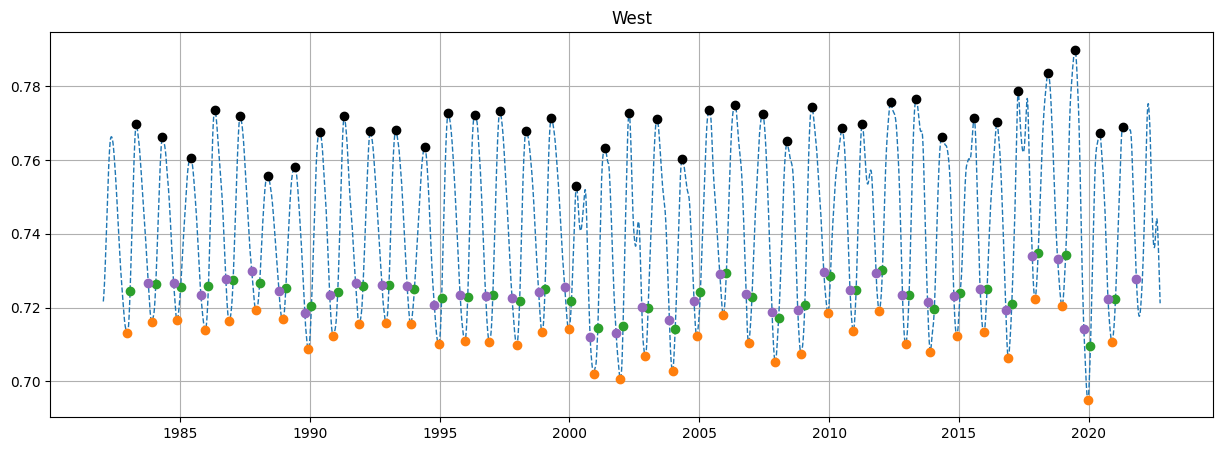

In [49]:
ds = results[k] #'Recherche rainfed crop'

fig,ax=plt.subplots(1,1, figsize=(15,5))
ds.plot(ax=ax, color='tab:blue', linestyle='--', linewidth=1.0, label='Daily NDVI') #.sel(time=slice('1997','2016'))

# ax.set_ylim(0.1, 0.9)
ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].SOS.values, eco_regions_phenometrics[k].SOS_year.values)],
       y=eco_regions_phenometrics[k].vSOS,
      c='tab:green', label='SOS', zorder=10)

ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].EOS.values, eco_regions_phenometrics[k].EOS_year.values)],
       y=eco_regions_phenometrics[k].vEOS,
      c='tab:purple', label='EOS', zorder=10)

ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].POS.values, eco_regions_phenometrics[k].POS_year.values)],
           y=eco_regions_phenometrics[k].vPOS,
          c='black', label='POS', zorder=10)

ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].TOS.values, eco_regions_phenometrics[k].TOS_year.values)],
       y=eco_regions_phenometrics[k].vTOS,
      c='tab:orange', label='TOS', zorder=10)

ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title(k, fontsize=12)
ax.grid()

[4]
num peaks: 1


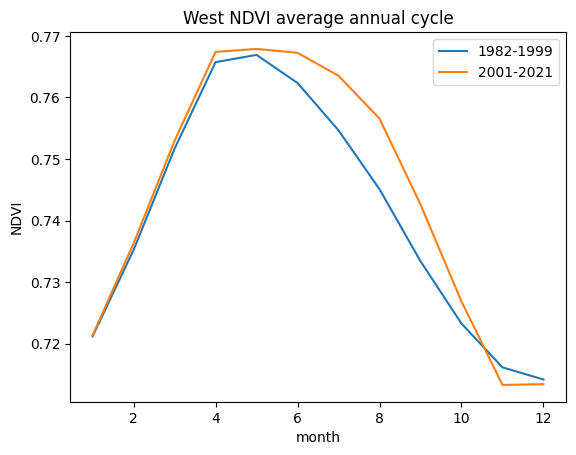

In [50]:
ds = results[k]
ds.sel(time=slice('1982','2001')).groupby('time.month').median().plot(label='1982-1999')
ds.sel(time=slice('2001','2021')).groupby('time.month').median().plot(label='2001-2021')
plt.legend()
plt.title(k+' NDVI average annual cycle');
# plt.ylim(0.4,0.8)
dd = ds.sel(time=slice('2000','2021')).groupby('time.month').mean().data
print(find_peaks(dd, prominence=0.005)[0])
print('num peaks:', len(find_peaks(dd, prominence=0.005)[0]))

In [44]:
# from astropy.stats import circmean, circstd
from scipy.stats import circmean, circstd
import numpy as np

def remove_circular_outliers_and_unwrap(
    angles,
    n_sigma: float = 2
):
    """
    Detect outliers in circular data using circular statistics from Astropy and SciPy.
    
    Parameters:
    -----------
    angles : array-like
        Angular data in radians
    n_sigma : float, optional (default=2.0)
        Number of circular standard deviations to use for outlier detection
        
    Returns:
    --------
    result : Data with outliers removed and np.unwrap applied
    """
    data_copy = angles.copy()
    angles = np.asarray(angles)
    
    # Calculate circular statistics
    mean_angle = circmean(angles)
    std_angle = circstd(angles)
    
    # Calculate circular distances from mean
    distances = np.abs(np.angle(np.exp(1j * (angles - mean_angle))))
    # distances = np.abs(((angles - mean_angle) + np.pi) % (2 * np.pi) - np.pi)

    # Identify outliers based on circular standard deviation
    outlier_mask = distances > (n_sigma * std_angle)

    # Create boolean mask for outliers
    # outlier_mask = np.zeros(len(data), dtype=bool)
    # outlier_mask[outlier_indices] = True
    
    # Remove outliers
    clean_data = data_copy[~outlier_mask]
    
    # Apply unwrap to clean data
    unwrapped_clean = np.unwrap(clean_data)
    
    # Create output array filled with nan
    result = np.full_like(data_copy, np.nan, dtype=float)
    
    # Fill in the unwrapped values at non-outlier positions
    result[~outlier_mask] = unwrapped_clean
    
    return result

In [45]:
df = eco_regions_phenometrics[k]

data = pd.DataFrame({
    "year": df[f'{var}_year'].values,
    "day_of_year": df[var].values
})

# Number of days in a year (adjusting for leap years)
data['days_in_year'] = data['year'].apply(lambda y: 366 if y % 4 == 0 and (y % 100 != 0 or y % 400 == 0) else 365)

# Convert day-of-year to circular coordinates doy / 365 * 2 * np.pi
data['theta'] = data['day_of_year']*((2*np.pi)/data['days_in_year'])

# Remove outliers where 1.5 std devs. 
data['theta_unwrap'] = remove_circular_outliers_and_unwrap(data['theta'], n_sigma=2)

# threshold = 275 # Maximum allowable jump before assuming wraparound
# data['theta_unwrap'] = np.unwrap(data['theta']) #discont=2*np.pi*threshold/365

# Calculate circular mean
circular_mean = circmean(data['theta'], nan_policy='omit')
circular_std = circstd(data['theta'], nan_policy='omit')

circular_mean_doy = circular_mean / (2 * np.pi) * 365
circular_std_doy = circular_std / (2 * np.pi) * 365
print(f"Circular mean {var} DOY: {circular_mean_doy}")
print(f"Circular std. dev. {var} DOY: {circular_std_doy}")
print(f"Linear mean {var} DOY: {df[var].mean()}")
print(f"Linear std. dev. {var} DOY: {df[var].std()}")
print('\n')

# find  slope of components as alternative method.
# This is bullshit! Can't interprete components seperately according to
# https://stats.stackexchange.com/questions/525561/interpreting-multiple-circular-circular-regression-output
# When doing linear regression with circular components need to include both the sin and cos components 
# but can't interpret the beta coefficients seperately.

data['x'] = np.cos(data['theta'])
data['y'] = np.sin(data['theta'])
p_value_x, slope_x, intercept_x = mk_with_slopes(data['x'])
p_value_y, slope_y, intercept_y = mk_with_slopes(data['y'])

slope_magnitude = np.sqrt(slope_x**2 + slope_y**2)
slope_magnitude_doy = slope_magnitude * 365 / (2 * np.pi)

# Determine if the trend is toward later (+1) or earlier (-1) dates
# Direction near 90° (π/2) means trending later, near 270° (3π/2) means earlier
# Calculate the overall direction and magnitude
direction = np.arctan2(slope_y, slope_x)
trend_direction = 1 if -np.pi/2 < direction < np.pi/2 else -1
slope_magnitude_doy *= trend_direction
combined_p_value = max(p_value_x, p_value_y)

p_value, slope, intercept = mk_with_slopes(data['theta_unwrap'])
# slope, intercept, r_value, p_value, std_err = linregress(data.index, data['theta_unwrap'])
slope_doy = slope * 365 / (2 * np.pi)

print(f"{var} circular slope magnitude (unwrapped theta): {slope:.4f}")
print(f"{var} circular slope magnitude (unwrapped theta) converted to DOY units: {slope_doy:.4f}")
# print(f"{var} circular slope magnitude (x+y): {slope_magnitude:.4f}")
print(f"{var} circular slope magnitude (x+y) converted to DOY units: {slope_magnitude_doy:.4f}")
print(f"{var} linear slope magnitude: {mk_with_slopes(df[var]).slope}")
print('\n')
print(f"{var} circular (unwrapped theta) p-value: {p_value:.4f}")
print(f"{var} circular (x+y) p-value: {combined_p_value:.4f}")
print(f"{var} linear p-value: {mk_with_slopes(df[var]).p:.4f}")

Circular mean SOS DOY: 327.6609928086467
Circular std. dev. SOS DOY: 11.717834689768559
Linear mean SOS DOY: 327.8717956542969
Linear std. dev. SOS DOY: 11.872523307800293


SOS circular slope magnitude (unwrapped theta): -0.0063
SOS circular slope magnitude (unwrapped theta) converted to DOY units: -0.3636
SOS circular slope magnitude (x+y) converted to DOY units: -0.3307
SOS linear slope magnitude: -0.36363636363636365


SOS circular (unwrapped theta) p-value: 0.0591
SOS circular (x+y) p-value: 0.0772
SOS linear p-value: 0.0711


In [46]:
data.to_csv('/g/data/os22/chad_tmp/Aus_phenology/test_data.csv')

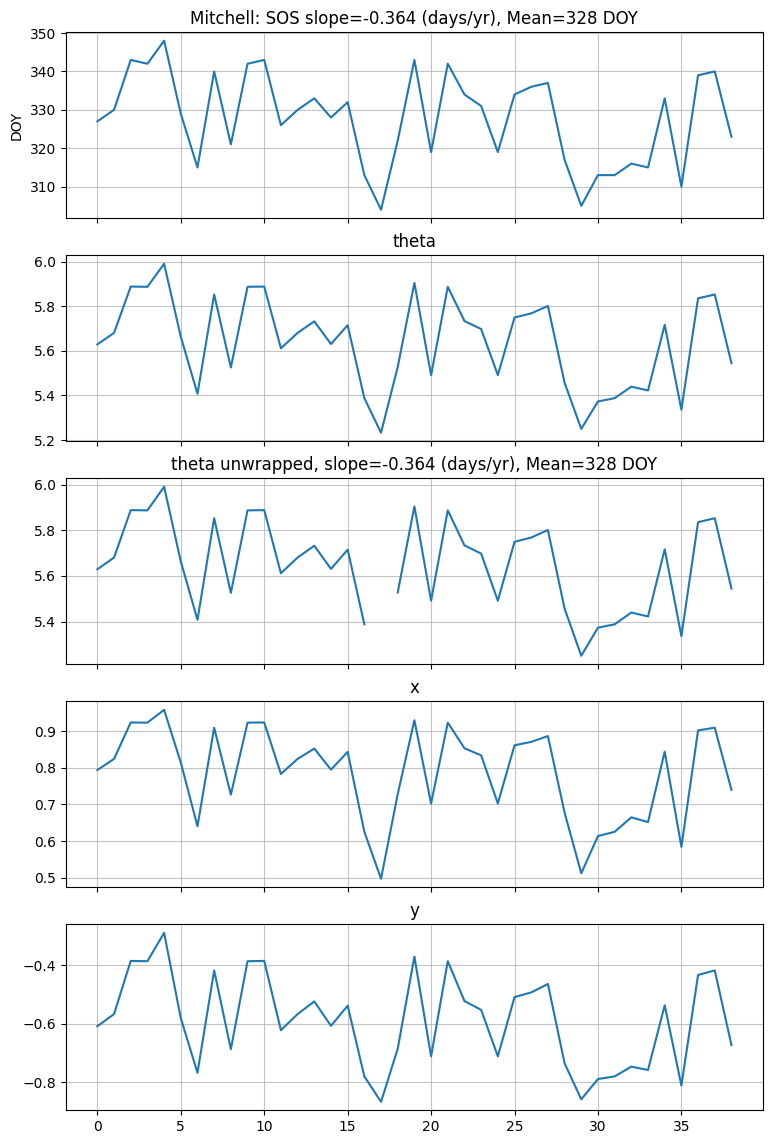

In [47]:
fig,ax=plt.subplots(5,1, figsize=(9,14), sharex=True)

df[var].plot(ax=ax[0])
data['theta'].plot(ax=ax[1],label='theta')
data['theta_unwrap'].plot(ax=ax[2],label=f'x, slope={slope:.4f}')
# ax[2].plot(theta_unwrap,label=f'x, slope={slope:.4f}')
data['x'].plot(ax=ax[3],label='x')
data['y'].plot(ax=ax[4],label='y')

ax[0].grid(alpha=0.75)
ax[1].grid(alpha=0.75)
ax[2].grid(alpha=0.75)
ax[3].grid(alpha=0.75)
ax[4].grid(alpha=0.75)
ax[0].set_ylabel('DOY')
ax[0].set_title(f'{k}: {var} slope={mk_with_slopes(df[var]).slope:.3f} (days/yr), Mean={df[var].mean():.0f} DOY')
ax[1].set_title('theta')
ax[2].set_title(f'theta unwrapped, slope={slope_doy:.3f} (days/yr), Mean={circular_mean_doy:.0f} DOY');
ax[3].set_title('x')
ax[4].set_title('y');

In [ ]:
# if np.abs(slope_doy) > 3*np.abs(slope_magnitude_doy):
#     linear = mk_with_slopes(df[var]).slope
#     trend_direction = -1 if linear < 0 else 1
#     slope_doy = np.abs(slope_magnitude_doy)*trend_direction
#     print(f"{var} slope magnitude converted to DOY units: {slope_doy:.4f}")

# linear = mk_with_slopes(df[var].squeeze().values)
# if np.abs(slope_doy) > 3*np.abs(linear.slope):
#     slope_doy = linear.slope
#     p_value = linear.p
#     print(f"{var} slope magnitude converted to DOY units: {slope_doy:.4f}")

## Test func for LC-regression

In [41]:
x = data.index.values
x = x-np.mean(x) #centre 
y_obs = data['theta']
weights = np.ones_like(x)  # Equal weights for simplicity

# Fit the model
optimal_params, objective_value = fit_circular_model(x, y_obs, weights)
fitted_mu, fitted_beta = optimal_params

# Compute p-value for beta
p_value_gpt = permutation_test(x=x, y_obs=y_obs, weights=weights, fitted_beta=fitted_beta, num_permutations=200)
p_value_claude = calculate_beta_significance(x, y_obs, weights, kappa=1, wls_weight=0.5)

print(f"Fitted μ: {fitted_mu:.4f}, Fitted β: {fitted_beta:.4f}", f'Converged in {iter} iterations')
print(f"Fitted DOY μ: {fitted_mu* 365 / (2 * np.pi):.4f}, Fitted DOY β: {fitted_beta* 365 / (2 * np.pi):.4f}")
print(f"p-value GPT: {p_value_gpt:.4f}")
print(f"p-value Claude: {p_value_claude:.4f}")
print(f"linear p-value: {mk_with_slopes(df[var]).p:.4f}")
print(f"Circular (unwrapped theta) p-value: {p_value:.4f}")

Fitted μ: 3.7050, Fitted β: -0.0022 Converged in <built-in function iter> iterations
Fitted DOY μ: 215.2300, Fitted DOY β: -0.1282
p-value GPT: 0.0746
p-value Claude: 0.7579
linear p-value: 0.0710
Circular (unwrapped theta) p-value: 0.1409


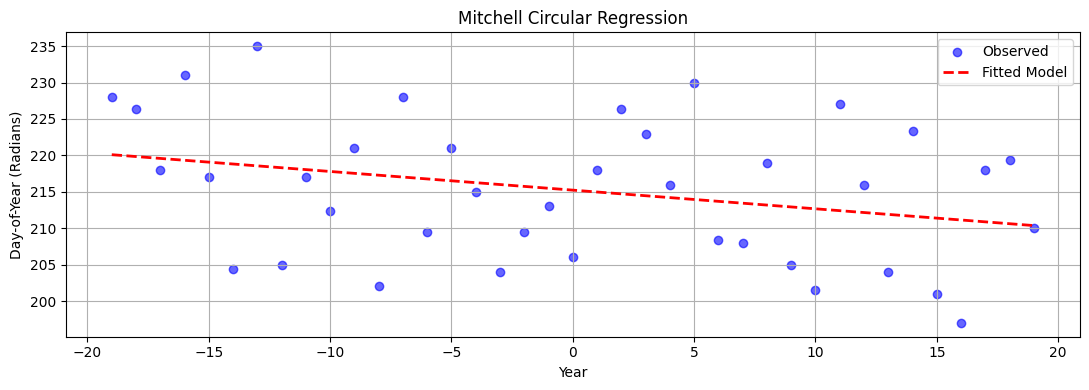

In [42]:
# Fit a circular regression model using true mu and beta
y_pred = circular_model(fitted_mu, fitted_beta, x)

# Visualization
plt.figure(figsize=(11, 4))
plt.scatter(x, y_obs*365/(2*np.pi), color='blue', alpha=0.6, label="Observed")
plt.plot(x, y_pred*365/(2*np.pi), color='red', linestyle='--', label="Fitted Model", linewidth=2)
plt.xlabel("Year")
plt.ylabel("Day-of-Year (Radians)")
plt.title(k+" Circular Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Test function for circular-linear correlation

In [ ]:
import numpy as np
import pandas as pd
import pingouin as pg
from scipy.stats import pearsonr, chi2

def parcorr_with_circular_vars(data, circular_vars, linear_vars, target_var):
    """
    Calculate partial correlations between variables and a target using pingouin,
    properly handling circular variables by decomposing them into sine and cosine components.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing all variables
    circular_vars (list): List of column names for circular variables (in DOY)
    linear_vars (list): List of column names for linear variables
    target_var (str): Name of the target variable
    
    Returns:
    pd.DataFrame: Partial correlations with p-values
    """
    # Convert circular variables to sine and cosine components
    expanded_data = data.copy()
    
    for var in circular_vars:
        # Convert DOY to radians
        radians = 2 * np.pi * (data[var] - 1) / 366
        
        # Create sine and cosine components
        expanded_data[f"{var}_sin"] = np.sin(radians)
        expanded_data[f"{var}_cos"] = np.cos(radians)
        
        # Drop original circular variable
        expanded_data = expanded_data.drop(columns=[var])
    
    # Create list of all predictor variables
    circular_components = [f"{var}_{comp}" for var in circular_vars 
                         for comp in ['sin', 'cos']]

    all_predictors = circular_components + linear_vars
    
    expanded_data = expanded_data[[target_var]+all_predictors]
    
    # Calculate partial correlation between all vars
    results_df = pg.pairwise_corr(expanded_data,
            columns=[target_var]) #[[target_var],all_predictors]
    
    # # Process final results
    final_results = []
    
    # Process linear variables directly
    for var in linear_vars:
        row = results_df[results_df['Y'] == var].iloc[0]

        final_results.append({
            'Y': var,
            'r': row['r'],
            # 'p': row['p-unc']
        })
    
    # Combine sine and cosine components for circular variables
    for var in circular_vars:
        sin_row = results_df[results_df['Y'] == f"{var}_sin"].iloc[0]
        cos_row = results_df[results_df['Y'] == f"{var}_cos"].iloc[0]
        n = len(expanded_data[f"{var}_cos"])
        
        # Calculate magnitude of correlation, reimplementation of here: 
        # https://pingouin-stats.org/build/html/_modules/pingouin/circular.html#circ_corrcl
        rcs = pearsonr(expanded_data[f"{var}_sin"], expanded_data[f"{var}_cos"])[0]
        rxc = cos_row['r']
        rxs = sin_row['r']
       
        r = np.sqrt((rxc**2 + rxs**2 - 2 * rxc * rxs * rcs) / (1-rcs**2))
       
        # Compute p-value
        p_value = chi2.sf(n * r**2, 2)
        
        final_results.append({
            'Y': var,
            'r': r,
            # 'p': p_value
        })
    
    return pd.DataFrame(final_results).set_index('Y').transpose().reset_index(drop=False)

In [ ]:
# Define variable groups
circular_vars = ['SOS', 'EOS', 'POS']
linear_vars = ['vPOS', 'vSOS', 'vEOS', 'LOS']
target_var = 'IOS'

# Calculate partial correlations
corr_df = parcorr_with_circular_vars(df, circular_vars, linear_vars, target_var)

print(corr_df.round(3))

# corr_linear_df = pg.pairwise_corr(df, columns=[[target_var], linear_vars+circular_vars])
# corr_linear_df = corr_linear_df[['X', 'Y', 'r', 'p-unc']]
# corr_linear_df['Abs_Correlation'] = np.abs(corr_linear_df['r'])
# corr_linear_df = corr_linear_df.sort_values('Abs_Correlation', ascending=False)
# corr_linear_df = corr_linear_df.drop('Abs_Correlation', axis=1)
# print("\nPartial Correlations with IOS:")
# print(corr_linear_df.round(3))

In [ ]:
k = 'Otway Ranges' # Claraville Plains Eastern Darling Downs rainfed crop Geraldton Hills rainfed crop

ds = eco_regions_phenometrics[k].to_xarray().expand_dims(latitude=[-33.0],longitude=[135.0])

template = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/templates/template_integral_parcorr.nc')

In [ ]:
from phenology_pixel_circular import IOS_analysis

In [ ]:
IOS_analysis(ds, template=template).compute()

## Test func for perpixel circular mean

In [ ]:
from odc.algo._percentile import xr_quantile

In [ ]:
k = 'Eastern Darling Downs rainfed crop' # Claraville Plains Eastern Darling Downs rainfed crop Geraldton Hills rainfed crop

ds = eco_regions_phenometrics[k].to_xarray().expand_dims(latitude=[-33.0],longitude=[135.0])

In [ ]:
def circular_mean_and_median(ds):
    # count number of seasons
    # and how many years was this over?
    n_seasons = len(ds.index)
    
    a = ds.POS_year.isel(index=0).values.item()
    b = ds.POS_year.isel(index=-1).values.item()
    
    if np.isnan(a):
        n_years=39
    else:
        n_years = len([i for i in range(int(a),int(b)+1)])
    
    #first check if its nodata and do a quick mean
    # if ds.vPOS.isel(index=0).values.item() == -99.0:
    if np.isnan(ds.vPOS.isel(index=0).values.item()):
        dd = ds.mean('index')
        
    else: 
        #calculate circular statistics for seasonal timings
        circ_stats = []
        for var in ['SOS', 'POS', 'EOS', 'TOS']:
            
            data = pd.DataFrame({
                "year": ds[f'{var}_year'].squeeze().values,
                "day_of_year": ds[var].squeeze().values
            })
        
            # Number of days in a year (adjusting for leap years)
            data['days_in_year'] = data['year'].apply(lambda y: 366 if y % 4 == 0 and (y % 100 != 0 or y % 400 == 0) else 365)
            
            # Convert day-of-year to circular coordinates doy / 365 * 2 * np.pi
            data['theta'] = data['day_of_year']*((2*np.pi)/data['days_in_year'])
            data['theta_unwrap'] = np.unwrap(data['theta'])
            
            # Calculate circular mean, convert back to DOY
            circular_mean = circmean(data['theta'], nan_policy='omit')
            circular_std = circstd(data['theta'], nan_policy='omit')
            circular_mean_doy = circular_mean / (2 * np.pi) * 365
            # circular_std_doy = circular_std / (2 * np.pi) * 365
        
            df = pd.DataFrame({
                f'{var}': [circular_mean_doy],
                # f'{var}_std': [circular_std_doy],
                })
        
            circ_stats.append(df)

        # For the other variables use Kirill's much much faster quantile function (median stats)
        dd_circ = pd.concat(circ_stats, axis=1).to_xarray().squeeze().expand_dims(latitude=ds.latitude,longitude=ds.longitude).drop_vars('index')
        ds = ds.transpose('index', 'latitude', 'longitude')
        other_vars=['vTOS','vSOS','vPOS','vEOS','AOS','LOS','IOS','IOC','LOC','ROG','ROS']
        dd_median = xr_quantile(ds[other_vars], quantiles=[0.5], nodata=np.nan)
        dd_median = dd_median.sel(quantile=0.5).drop_vars('quantile')
        
        dd = xr.merge([dd_median, dd_circ]).astype('float32')

    # add new variable with number of seasons
    dd['n_seasons'] = n_seasons
    dd['n_seasons'] = dd['n_seasons'].expand_dims(
        latitude=dd.latitude,
        longitude=dd.longitude
    )
    
    dd['n_years'] = n_years
    dd['n_years'] = dd['n_years'].expand_dims(
        latitude=dd.latitude,
        longitude=dd.longitude
    )
    return dd


In [ ]:
circular_mean_and_median(ds)

## Test func for perpixel trend on circular variable

In [ ]:
def phenology_trends(ds, vars):
    """
    Calculate robust statistics over phenology
    time series using MannKendal/Theil-Sen.
    """
    slopes=[]
    p_values=[]
    for var in vars:
        if any(var in x for x in ['SOS', 'POS', 'EOS', 'TOS']):
            # If variabes are circular, then convert to radians
            data = pd.DataFrame({
                "year": ds[f'{var}_year'].squeeze().values,
                "day_of_year": ds[var].squeeze().values
                })
    
            # Number of days in a year (adjusting for leap years)
            data['days_in_year'] = data['year'].apply(lambda y: 366 if y % 4 == 0 and (y % 100 != 0 or y % 400 == 0) else 365)
            
            # Convert day-of-year to circular coordinates: doy / 365 * 2 * np.pi
            # Then unwrap to deal with calendar crossing and do linear trend on unwrapped theta
            data['theta'] = data['day_of_year']*((2*np.pi)/data['days_in_year'])
            data['theta_unwrap'] = np.unwrap(data['theta'])
            p_value, slope, intercept = mk_with_slopes(data['theta_unwrap'])
            slope_doy = slope * 365 / (2 * np.pi)
            
            # Now check if the componenets slope magnitude is similar
            # to the linear slope mangnitude. If they diverge greatly then
            # the theta unwrap method has introduced discontinuities and we revert
            # to the simple linear method.
            linear = mk_with_slopes(ds[var].squeeze().values)
            if np.abs(slope_doy) > 3*np.abs(linear.slope):
                slope_doy = linear.slope
                p_value = linear.p
             
            df = pd.DataFrame({
                f'{var}_slope': [slope_doy],
                f'{var}_p_value': [p_value],
                })
            
            dss = df.to_xarray().squeeze().expand_dims(latitude=ds.latitude,longitude=ds.longitude).drop_vars('index')
            
            slopes.append(dss[f'{var}_slope'])
            p_values.append(dss[f'{var}_p_value'])
        
        else:
            # for the other variables take the simple robust slope
            # no need to transform into radians
            out = xr.apply_ufunc(mk_with_slopes,
                          ds[var],
                          input_core_dims=[["index"]],
                          output_core_dims=[[],[],[],],
                          vectorize=True)
            
            #grab the slopes and p-value
            p = out[0].rename(var+'_p_value')
            s = out[1].rename(var+'_slope')
            # i = out[2].rename(var+'_intercept')
        
            slopes.append(s)
            p_values.append(p)
            # intercept.append(i)
    
        #merge all the variables
        slopes_xr = xr.merge(slopes)
        p_values_xr = xr.merge(p_values)
        # intercept_xr = xr.merge(intercept)

    #export a dataset
    return xr.merge([slopes_xr,p_values_xr]).astype('float32')

In [ ]:
stats = ['SOS', 'POS', 'EOS', 'TOS','vTOS','vSOS','vPOS','vEOS','AOS','LOS','IOS','IOC','LOC','ROG','ROS']

dss = phenology_trends(ds, stats)
dss